In [1]:
# Load brain data and mask

# Access nifti, bval & bvec files
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii')
mask = join(dname, 'vol0083_brain_mask.nii.gz')
fbval = join(dname, 'parameters_new_bval.txt')
fbvec = join(dname, 'parameters_new_bvec2.txt')

# Load dMRI datasets 
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)
mask_data, affine1, img1 = load_nifti(mask, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

(77, 92, 56, 1344)


In [16]:
# Set up acquisition scheme using bval, bvec

# Import relevant modules
from dmipy.core import modeling_framework
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from os.path import join
import numpy as np

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))
grad_echo_inv = np.loadtxt(join('parameters_new.txt'))

# delta and Delta times in seconds
delta = 0.0242
Delta = 0.0391

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 4

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |84        |0               |0                        |24.2       |39.1      |N/A  
1           |84        |500             |19                       |24.2       |39.1      |N/A  
2           |252       |1000            |27                       |24.2       |39.1      |N/A  
3           |420       |2000            |39                       |24.2       |39.1      |N/A  
4           |504       |3000            |48                       |24.2       |39.1      |N/A  


In [9]:
print(grad_echo_inv)
ti = grad_echo_inv[:,4]
te = grad_echo_inv[:,5]
print(ti)
print(te)

[[-5.2602e-01 -7.1803e-01 -4.5578e-01  3.0000e+03  2.0000e+01  8.0000e+01]
 [-5.2602e-01 -7.1803e-01 -4.5578e-01  3.0000e+03  1.2364e+03  8.0000e+01]
 [-5.2602e-01 -7.1803e-01 -4.5578e-01  3.0000e+03  2.4727e+03  8.0000e+01]
 ...
 [ 4.9906e-01 -6.8361e-01  5.3255e-01  2.0000e+03  2.2961e+03  1.3000e+02]
 [ 4.9906e-01 -6.8361e-01  5.3255e-01  2.0000e+03  3.5325e+03  1.3000e+02]
 [ 4.9906e-01 -6.8361e-01  5.3255e-01  2.0000e+03  7.3227e+03  1.3000e+02]]
[  20.  1236.4 2472.7 ... 2296.1 3532.5 7322.7]
[ 80.  80.  80. ... 130. 130. 130.]


In [26]:
sub_data = data[:,:,:,te==80]
print(sub_data.shape)
sub_data = data[:,:,:,(ti>=3000) & (te==80) & (bvalues==3000)]
print(sub_data.shape) 

(77, 92, 56, 448)
(77, 92, 56, 66)


In [3]:
# Create sphere & stick model

# Import relevant modules
from dmipy.signal_models import cylinder_models, sphere_models
from dmipy.core.modeling_framework import MultiCompartmentModel

# Create ball and stick model
stick = cylinder_models.C1Stick()
sphere = sphere_models.S4SphereGaussianPhaseApproximation()
sphere_and_stick = MultiCompartmentModel(models=[sphere, stick])

print(sphere_and_stick.parameter_cardinality)

OrderedDict([('S4SphereGaussianPhaseApproximation_1_diameter', 1), ('C1Stick_1_mu', 2), ('C1Stick_1_lambda_par', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])


In [ ]:
import numpy as np

diameter = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['S4SphereGaussianPhaseApproximation_1_diameter'])
            diameter[x,y,:] = fitted_SAS.fitted_parameters['S4SphereGaussianPhaseApproximation_1_diameter']
            print((x, y))
            
print(diameter)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(diameter[:,:,0])
ax2.imshow(diameter[:,:,1])
ax1.set_title('S4SphereGaussianPhaseApproximation_1_diameter')
ax2.set_title('S4SphereGaussianPhaseApproximation_1_diameter')

In [ ]:
with open('diameter.txt', 'w') as file:
    for line in diameter:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
import numpy as np

part_vol_zero = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['partial_volume_0'])
            part_vol_zero[x,y,:] = fitted_SAS.fitted_parameters['partial_volume_0']
            print((x, y))
            
print(part_vol_zero)

NameError: name 'part_vol_zero' is not defined

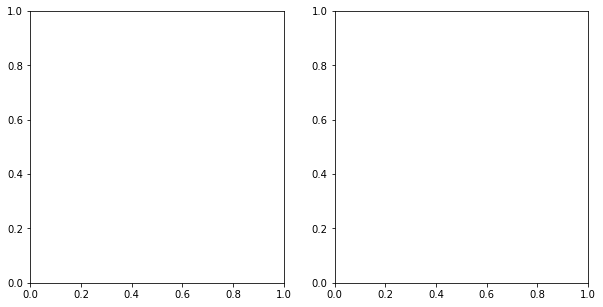

In [6]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(part_vol_zero[:,:,0])
ax2.imshow(part_vol_zero[:,:,1])
ax1.set_title('partial_volume_0')
ax2.set_title('partial_volume_0')

In [ ]:
with open('SAS_partial_volume_0.txt', 'w') as file:
    for line in part_vol_zero:
        file.write("%s\n" %line)
        
file.close()

In [4]:
import numpy as np

part_vol_one = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['partial_volume_1'])
            part_vol_one[x,y,:] = fitted_SAS.fitted_parameters['partial_volume_1']
            print((x, y))
            
print(part_vol_one)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.262718915939331 seconds
Fitting of 1 voxels complete in 1.2430419921875 seconds.
Average of 1.2430419921875 seconds per voxel.
[0.36602025]
(14, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1837739944458008 seconds
Fitting of 1 voxels complete in 0.06710505485534668 seconds.
Average of 0.06710505485534668 seconds per voxel.
[0.38235761]
(14, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1931209564208984 seconds
Fitting of 1 voxels complete in 0.0643150806427002 seconds.
Average of 0.0643150806427002 seconds per voxel.
[0.38620217]
(14, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1850848197937012 seconds
Fitting of 1 voxels complete in 0.06450390815734863 seconds.
Average of 0.06450390815734863 seconds per voxel.
[0.36668739]
(14, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.186335086

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3531062602996826 seconds
Fitting of 1 voxels complete in 0.072296142578125 seconds.
Average of 0.072296142578125 seconds per voxel.
[0.29982449]
(16, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.302060842514038 seconds
Fitting of 1 voxels complete in 0.09633612632751465 seconds.
Average of 0.09633612632751465 seconds per voxel.
[0.30674853]
(16, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2484700679779053 seconds
Fitting of 1 voxels complete in 0.06725502014160156 seconds.
Average of 0.06725502014160156 seconds per voxel.
[0.35801744]
(16, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1815099716186523 seconds
Fitting of 1 voxels complete in 0.0837550163269043 seconds.
Average of 0.0837550163269043 seconds per voxel.
[0.44747419]
(16, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.18183

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1646437644958496 seconds
Fitting of 1 voxels complete in 0.054975032806396484 seconds.
Average of 0.054975032806396484 seconds per voxel.
[0.39257515]
(18, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1672289371490479 seconds
Fitting of 1 voxels complete in 0.05714106559753418 seconds.
Average of 0.05714106559753418 seconds per voxel.
[0.31142008]
(18, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1681978702545166 seconds
Fitting of 1 voxels complete in 0.058381080627441406 seconds.
Average of 0.058381080627441406 seconds per voxel.
[0.26579296]
(18, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1789298057556152 seconds
Fitting of 1 voxels complete in 0.09514904022216797 seconds.
Average of 0.09514904022216797 seconds per voxel.
[0.28603443]
(18, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1724538803100586 seconds
Fitting of 1 voxels complete in 0.05983781814575195 seconds.
Average of 0.05983781814575195 seconds per voxel.
[0.34498993]
(19, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.193540096282959 seconds
Fitting of 1 voxels complete in 0.06032085418701172 seconds.
Average of 0.06032085418701172 seconds per voxel.
[0.31705481]
(19, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2168090343475342 seconds
Fitting of 1 voxels complete in 0.05940699577331543 seconds.
Average of 0.05940699577331543 seconds per voxel.
[0.31151615]
(19, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2132899761199951 seconds
Fitting of 1 voxels complete in 0.05578327178955078 seconds.
Average of 0.05578327178955078 seconds per voxel.
[0.31318941]
(19, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6339218616485596 seconds
Fitting of 1 voxels complete in 0.09105801582336426 seconds.
Average of 0.09105801582336426 seconds per voxel.
[0.4235827]
(19, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5321531295776367 seconds
Fitting of 1 voxels complete in 0.0713951587677002 seconds.
Average of 0.0713951587677002 seconds per voxel.
[0.44905268]
(20, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.031095027923584 seconds
Fitting of 1 voxels complete in 0.05588817596435547 seconds.
Average of 0.05588817596435547 seconds per voxel.
[0.39545787]
(20, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2091600894927979 seconds
Fitting of 1 voxels complete in 0.0714576244354248 seconds.
Average of 0.0714576244354248 seconds per voxel.
[0.3285654]
(20, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.17787

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1744701862335205 seconds
Fitting of 1 voxels complete in 0.06378793716430664 seconds.
Average of 0.06378793716430664 seconds per voxel.
[0.45814988]
(20, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2132318019866943 seconds
Fitting of 1 voxels complete in 0.07412028312683105 seconds.
Average of 0.07412028312683105 seconds per voxel.
[0.38026137]
(20, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1800251007080078 seconds
Fitting of 1 voxels complete in 0.07643508911132812 seconds.
Average of 0.07643508911132812 seconds per voxel.
[0.27065259]
(20, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1837241649627686 seconds
Fitting of 1 voxels complete in 0.06680703163146973 seconds.
Average of 0.06680703163146973 seconds per voxel.
[0.3209415]
(20, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1912147998809814 seconds
Fitting of 1 voxels complete in 0.062209129333496094 seconds.
Average of 0.062209129333496094 seconds per voxel.
[0.3276773]
(21, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.179725170135498 seconds
Fitting of 1 voxels complete in 0.06832695007324219 seconds.
Average of 0.06832695007324219 seconds per voxel.
[0.29360331]
(21, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.186033010482788 seconds
Fitting of 1 voxels complete in 0.06218600273132324 seconds.
Average of 0.06218600273132324 seconds per voxel.
[0.29243805]
(21, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1722097396850586 seconds
Fitting of 1 voxels complete in 0.06796908378601074 seconds.
Average of 0.06796908378601074 seconds per voxel.
[0.26472448]
(21, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1956748962402344 seconds
Fitting of 1 voxels complete in 0.06556892395019531 seconds.
Average of 0.06556892395019531 seconds per voxel.
[0.25904668]
(22, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.17769193649292 seconds
Fitting of 1 voxels complete in 0.06098198890686035 seconds.
Average of 0.06098198890686035 seconds per voxel.
[0.2506521]
(22, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1835088729858398 seconds
Fitting of 1 voxels complete in 0.0609898567199707 seconds.
Average of 0.0609898567199707 seconds per voxel.
[0.28367058]
(22, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.186481237411499 seconds
Fitting of 1 voxels complete in 0.06216597557067871 seconds.
Average of 0.06216597557067871 seconds per voxel.
[0.30447746]
(22, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1859

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1871418952941895 seconds
Fitting of 1 voxels complete in 0.05969595909118652 seconds.
Average of 0.05969595909118652 seconds per voxel.
[0.32046622]
(23, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1872057914733887 seconds
Fitting of 1 voxels complete in 0.06043100357055664 seconds.
Average of 0.06043100357055664 seconds per voxel.
[0.30618512]
(23, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1787278652191162 seconds
Fitting of 1 voxels complete in 0.06116080284118652 seconds.
Average of 0.06116080284118652 seconds per voxel.
[0.37550606]
(23, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.195204257965088 seconds
Fitting of 1 voxels complete in 0.061721086502075195 seconds.
Average of 0.061721086502075195 seconds per voxel.
[0.31984952]
(23, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2104337215423584 seconds
Fitting of 1 voxels complete in 0.06398582458496094 seconds.
Average of 0.06398582458496094 seconds per voxel.
[0.28894094]
(23, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1793715953826904 seconds
Fitting of 1 voxels complete in 0.06235313415527344 seconds.
Average of 0.06235313415527344 seconds per voxel.
[0.27643194]
(23, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1755461692810059 seconds
Fitting of 1 voxels complete in 0.06034207344055176 seconds.
Average of 0.06034207344055176 seconds per voxel.
[0.27059912]
(23, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2144012451171875 seconds
Fitting of 1 voxels complete in 0.05892682075500488 seconds.
Average of 0.05892682075500488 seconds per voxel.
[0.3103172]
(23, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1767830848693848 seconds
Fitting of 1 voxels complete in 0.05844879150390625 seconds.
Average of 0.05844879150390625 seconds per voxel.
[0.26398146]
(24, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1936790943145752 seconds
Fitting of 1 voxels complete in 0.05449795722961426 seconds.
Average of 0.05449795722961426 seconds per voxel.
[0.29794917]
(24, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1741142272949219 seconds
Fitting of 1 voxels complete in 0.06272602081298828 seconds.
Average of 0.06272602081298828 seconds per voxel.
[0.30749916]
(24, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.185934066772461 seconds
Fitting of 1 voxels complete in 0.07010507583618164 seconds.
Average of 0.07010507583618164 seconds per voxel.
[0.31643018]
(24, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2611868381500244 seconds
Fitting of 1 voxels complete in 0.06248021125793457 seconds.
Average of 0.06248021125793457 seconds per voxel.
[0.25142963]
(25, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2051541805267334 seconds
Fitting of 1 voxels complete in 0.05968785285949707 seconds.
Average of 0.05968785285949707 seconds per voxel.
[0.34945193]
(25, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.215522050857544 seconds
Fitting of 1 voxels complete in 0.05751299858093262 seconds.
Average of 0.05751299858093262 seconds per voxel.
[0.38303415]
(25, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1838181018829346 seconds
Fitting of 1 voxels complete in 0.06179523468017578 seconds.
Average of 0.06179523468017578 seconds per voxel.
[0.32001581]
(25, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1919591426849365 seconds
Fitting of 1 voxels complete in 0.05763101577758789 seconds.
Average of 0.05763101577758789 seconds per voxel.
[0.32264831]
(25, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1871140003204346 seconds
Fitting of 1 voxels complete in 0.06627607345581055 seconds.
Average of 0.06627607345581055 seconds per voxel.
[0.41713187]
(25, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1855769157409668 seconds
Fitting of 1 voxels complete in 0.05371403694152832 seconds.
Average of 0.05371403694152832 seconds per voxel.
[0.37102764]
(25, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1866469383239746 seconds
Fitting of 1 voxels complete in 0.06317782402038574 seconds.
Average of 0.06317782402038574 seconds per voxel.
[0.31086845]
(25, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1867139339447021 seconds
Fitting of 1 voxels complete in 0.061464786529541016 seconds.
Average of 0.061464786529541016 seconds per voxel.
[0.28719425]
(26, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1887550354003906 seconds
Fitting of 1 voxels complete in 0.06288599967956543 seconds.
Average of 0.06288599967956543 seconds per voxel.
[0.29569051]
(26, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1922590732574463 seconds
Fitting of 1 voxels complete in 0.062151193618774414 seconds.
Average of 0.062151193618774414 seconds per voxel.
[0.27299271]
(26, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.176340103149414 seconds
Fitting of 1 voxels complete in 0.07098603248596191 seconds.
Average of 0.07098603248596191 seconds per voxel.
[0.2675689]
(26, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.191206693649292 seconds
Fitting of 1 voxels complete in 0.06253385543823242 seconds.
Average of 0.06253385543823242 seconds per voxel.
[0.33328596]
(26, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1895899772644043 seconds
Fitting of 1 voxels complete in 0.059497833251953125 seconds.
Average of 0.059497833251953125 seconds per voxel.
[0.38971939]
(26, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1849939823150635 seconds
Fitting of 1 voxels complete in 0.07099294662475586 seconds.
Average of 0.07099294662475586 seconds per voxel.
[0.4153888]
(26, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1816871166229248 seconds
Fitting of 1 voxels complete in 0.07496809959411621 seconds.
Average of 0.07496809959411621 seconds per voxel.
[0.41423148]
(26, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1803207397460938 seconds
Fitting of 1 voxels complete in 0.06407976150512695 seconds.
Average of 0.06407976150512695 seconds per voxel.
[0.242694]
(27, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1852717399597168 seconds
Fitting of 1 voxels complete in 0.06138801574707031 seconds.
Average of 0.06138801574707031 seconds per voxel.
[0.27572263]
(27, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1788992881774902 seconds
Fitting of 1 voxels complete in 0.06172800064086914 seconds.
Average of 0.06172800064086914 seconds per voxel.
[0.31655187]
(27, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1836950778961182 seconds
Fitting of 1 voxels complete in 0.06082510948181152 seconds.
Average of 0.06082510948181152 seconds per voxel.
[0.26909775]
(27, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4355158805847168 seconds
Fitting of 1 voxels complete in 0.10643291473388672 seconds.
Average of 0.10643291473388672 seconds per voxel.
[0.26833009]
(28, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.2982382774353027 seconds
Fitting of 1 voxels complete in 0.0659792423248291 seconds.
Average of 0.0659792423248291 seconds per voxel.
[0.26962037]
(28, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6022541522979736 seconds
Fitting of 1 voxels complete in 0.0711066722869873 seconds.
Average of 0.0711066722869873 seconds per voxel.
[0.26467036]
(28, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3086261749267578 seconds
Fitting of 1 voxels complete in 0.08024311065673828 seconds.
Average of 0.08024311065673828 seconds per voxel.
[0.24336111]
(28, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.25

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.646266222000122 seconds
Fitting of 1 voxels complete in 0.12037825584411621 seconds.
Average of 0.12037825584411621 seconds per voxel.
[0.27549828]
(28, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.533262252807617 seconds
Fitting of 1 voxels complete in 0.21561503410339355 seconds.
Average of 0.21561503410339355 seconds per voxel.
[0.32275748]
(28, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 4.3059117794036865 seconds
Fitting of 1 voxels complete in 0.17649173736572266 seconds.
Average of 0.17649173736572266 seconds per voxel.
[0.31110913]
(28, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 5.284585952758789 seconds
Fitting of 1 voxels complete in 0.09934592247009277 seconds.
Average of 0.09934592247009277 seconds per voxel.
[0.28618237]
(28, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 4.7

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2181251049041748 seconds
Fitting of 1 voxels complete in 0.0783388614654541 seconds.
Average of 0.0783388614654541 seconds per voxel.
[0.25001821]
(29, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.229010820388794 seconds
Fitting of 1 voxels complete in 0.07962512969970703 seconds.
Average of 0.07962512969970703 seconds per voxel.
[0.24343682]
(29, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.213437795639038 seconds
Fitting of 1 voxels complete in 0.06784796714782715 seconds.
Average of 0.06784796714782715 seconds per voxel.
[0.24974296]
(29, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2096397876739502 seconds
Fitting of 1 voxels complete in 0.06398487091064453 seconds.
Average of 0.06398487091064453 seconds per voxel.
[0.2643265]
(29, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.213

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2749261856079102 seconds
Fitting of 1 voxels complete in 0.06436491012573242 seconds.
Average of 0.06436491012573242 seconds per voxel.
[0.31321963]
(29, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2440369129180908 seconds
Fitting of 1 voxels complete in 0.09882020950317383 seconds.
Average of 0.09882020950317383 seconds per voxel.
[0.28888759]
(29, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3503081798553467 seconds
Fitting of 1 voxels complete in 0.07066798210144043 seconds.
Average of 0.07066798210144043 seconds per voxel.
[0.37302625]
(29, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3124969005584717 seconds
Fitting of 1 voxels complete in 0.08028793334960938 seconds.
Average of 0.08028793334960938 seconds per voxel.
[0.46544004]
(29, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2238948345184326 seconds
Fitting of 1 voxels complete in 0.07148075103759766 seconds.
Average of 0.07148075103759766 seconds per voxel.
[0.35061292]
(30, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.210625171661377 seconds
Fitting of 1 voxels complete in 0.07347321510314941 seconds.
Average of 0.07347321510314941 seconds per voxel.
[0.28801828]
(30, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3161139488220215 seconds
Fitting of 1 voxels complete in 0.06594705581665039 seconds.
Average of 0.06594705581665039 seconds per voxel.
[0.29894653]
(30, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4693818092346191 seconds
Fitting of 1 voxels complete in 0.0985417366027832 seconds.
Average of 0.0985417366027832 seconds per voxel.
[0.29911522]
(30, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6015479564666748 seconds
Fitting of 1 voxels complete in 0.06118321418762207 seconds.
Average of 0.06118321418762207 seconds per voxel.
[0.35050711]
(31, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.598712682723999 seconds
Fitting of 1 voxels complete in 0.0735008716583252 seconds.
Average of 0.0735008716583252 seconds per voxel.
[0.26101009]
(31, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1871387958526611 seconds
Fitting of 1 voxels complete in 0.07801604270935059 seconds.
Average of 0.07801604270935059 seconds per voxel.
[0.28042346]
(31, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1794219017028809 seconds
Fitting of 1 voxels complete in 0.06579089164733887 seconds.
Average of 0.06579089164733887 seconds per voxel.
[0.3077076]
(31, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.19

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.18485689163208 seconds
Fitting of 1 voxels complete in 0.07555985450744629 seconds.
Average of 0.07555985450744629 seconds per voxel.
[0.24223627]
(31, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1958951950073242 seconds
Fitting of 1 voxels complete in 0.06487107276916504 seconds.
Average of 0.06487107276916504 seconds per voxel.
[0.25941312]
(31, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2293388843536377 seconds
Fitting of 1 voxels complete in 0.09288311004638672 seconds.
Average of 0.09288311004638672 seconds per voxel.
[0.24941809]
(31, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2103898525238037 seconds
Fitting of 1 voxels complete in 0.06237292289733887 seconds.
Average of 0.06237292289733887 seconds per voxel.
[0.25651129]
(31, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2129850387573242 seconds
Fitting of 1 voxels complete in 0.06340312957763672 seconds.
Average of 0.06340312957763672 seconds per voxel.
[0.32047933]
(32, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1948809623718262 seconds
Fitting of 1 voxels complete in 0.060449838638305664 seconds.
Average of 0.060449838638305664 seconds per voxel.
[0.31490195]
(32, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1930811405181885 seconds
Fitting of 1 voxels complete in 0.06270313262939453 seconds.
Average of 0.06270313262939453 seconds per voxel.
[0.29698161]
(32, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1932463645935059 seconds
Fitting of 1 voxels complete in 0.06627106666564941 seconds.
Average of 0.06627106666564941 seconds per voxel.
[0.29458222]
(32, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.183372974395752 seconds
Fitting of 1 voxels complete in 0.061506032943725586 seconds.
Average of 0.061506032943725586 seconds per voxel.
[0.38261278]
(32, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1898648738861084 seconds
Fitting of 1 voxels complete in 0.055504798889160156 seconds.
Average of 0.055504798889160156 seconds per voxel.
[0.38710841]
(32, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1733739376068115 seconds
Fitting of 1 voxels complete in 0.06232714653015137 seconds.
Average of 0.06232714653015137 seconds per voxel.
[0.33512583]
(32, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.190136194229126 seconds
Fitting of 1 voxels complete in 0.06038784980773926 seconds.
Average of 0.06038784980773926 seconds per voxel.
[0.29209089]
(32, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1816911697387695 seconds
Fitting of 1 voxels complete in 0.06488871574401855 seconds.
Average of 0.06488871574401855 seconds per voxel.
[0.33915409]
(33, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.191154956817627 seconds
Fitting of 1 voxels complete in 0.05649399757385254 seconds.
Average of 0.05649399757385254 seconds per voxel.
[0.3811697]
(33, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1793768405914307 seconds
Fitting of 1 voxels complete in 0.059288978576660156 seconds.
Average of 0.059288978576660156 seconds per voxel.
[0.42015782]
(33, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1874089241027832 seconds
Fitting of 1 voxels complete in 0.0564730167388916 seconds.
Average of 0.0564730167388916 seconds per voxel.
[0.44347529]
(33, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1929290294647217 seconds
Fitting of 1 voxels complete in 0.07011580467224121 seconds.
Average of 0.07011580467224121 seconds per voxel.
[0.26504613]
(33, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1913936138153076 seconds
Fitting of 1 voxels complete in 0.06451797485351562 seconds.
Average of 0.06451797485351562 seconds per voxel.
[0.27189279]
(33, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1848559379577637 seconds
Fitting of 1 voxels complete in 0.062439918518066406 seconds.
Average of 0.062439918518066406 seconds per voxel.
[0.27849061]
(33, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1870570182800293 seconds
Fitting of 1 voxels complete in 0.05425310134887695 seconds.
Average of 0.05425310134887695 seconds per voxel.
[0.3041397]
(33, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1834430694580078 seconds
Fitting of 1 voxels complete in 0.0713200569152832 seconds.
Average of 0.0713200569152832 seconds per voxel.
[0.54710418]
(34, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1855826377868652 seconds
Fitting of 1 voxels complete in 0.06503033638000488 seconds.
Average of 0.06503033638000488 seconds per voxel.
[0.53046591]
(34, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1955442428588867 seconds
Fitting of 1 voxels complete in 0.05530285835266113 seconds.
Average of 0.05530285835266113 seconds per voxel.
[0.53850593]
(34, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1782431602478027 seconds
Fitting of 1 voxels complete in 0.07002091407775879 seconds.
Average of 0.07002091407775879 seconds per voxel.
[0.52832925]
(34, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1836271286010742 seconds
Fitting of 1 voxels complete in 0.06490612030029297 seconds.
Average of 0.06490612030029297 seconds per voxel.
[0.24840588]
(34, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1752698421478271 seconds
Fitting of 1 voxels complete in 0.05648398399353027 seconds.
Average of 0.05648398399353027 seconds per voxel.
[0.2871924]
(34, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1875648498535156 seconds
Fitting of 1 voxels complete in 0.05814719200134277 seconds.
Average of 0.05814719200134277 seconds per voxel.
[0.28316653]
(34, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1729538440704346 seconds
Fitting of 1 voxels complete in 0.08835196495056152 seconds.
Average of 0.08835196495056152 seconds per voxel.
[0.22907443]
(34, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1852271556854248 seconds
Fitting of 1 voxels complete in 0.06199193000793457 seconds.
Average of 0.06199193000793457 seconds per voxel.
[0.29128956]
(35, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1896579265594482 seconds
Fitting of 1 voxels complete in 0.07657003402709961 seconds.
Average of 0.07657003402709961 seconds per voxel.
[0.29522027]
(35, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1762890815734863 seconds
Fitting of 1 voxels complete in 0.06685519218444824 seconds.
Average of 0.06685519218444824 seconds per voxel.
[0.26749656]
(35, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1798248291015625 seconds
Fitting of 1 voxels complete in 0.06434988975524902 seconds.
Average of 0.06434988975524902 seconds per voxel.
[0.28895845]
(35, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1837003231048584 seconds
Fitting of 1 voxels complete in 0.0690758228302002 seconds.
Average of 0.0690758228302002 seconds per voxel.
[0.30020344]
(36, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1830689907073975 seconds
Fitting of 1 voxels complete in 0.06209707260131836 seconds.
Average of 0.06209707260131836 seconds per voxel.
[0.30630988]
(36, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1793489456176758 seconds
Fitting of 1 voxels complete in 0.06563091278076172 seconds.
Average of 0.06563091278076172 seconds per voxel.
[0.26260968]
(36, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1784162521362305 seconds
Fitting of 1 voxels complete in 0.0677042007446289 seconds.
Average of 0.0677042007446289 seconds per voxel.
[0.30438252]
(36, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.18

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.183044195175171 seconds
Fitting of 1 voxels complete in 0.057775259017944336 seconds.
Average of 0.057775259017944336 seconds per voxel.
[0.3260942]
(36, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1951549053192139 seconds
Fitting of 1 voxels complete in 0.05975484848022461 seconds.
Average of 0.05975484848022461 seconds per voxel.
[0.31428237]
(36, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2417750358581543 seconds
Fitting of 1 voxels complete in 0.055700063705444336 seconds.
Average of 0.055700063705444336 seconds per voxel.
[0.30875405]
(36, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1866679191589355 seconds
Fitting of 1 voxels complete in 0.06335902214050293 seconds.
Average of 0.06335902214050293 seconds per voxel.
[0.28314811]
(36, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.176914930343628 seconds
Fitting of 1 voxels complete in 0.08045220375061035 seconds.
Average of 0.08045220375061035 seconds per voxel.
[0.35116708]
(37, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.194868803024292 seconds
Fitting of 1 voxels complete in 0.06979084014892578 seconds.
Average of 0.06979084014892578 seconds per voxel.
[0.34224254]
(37, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1743149757385254 seconds
Fitting of 1 voxels complete in 0.06626296043395996 seconds.
Average of 0.06626296043395996 seconds per voxel.
[0.31847007]
(37, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1881728172302246 seconds
Fitting of 1 voxels complete in 0.06878471374511719 seconds.
Average of 0.06878471374511719 seconds per voxel.
[0.3026001]
(37, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1876299381256104 seconds
Fitting of 1 voxels complete in 0.060604095458984375 seconds.
Average of 0.060604095458984375 seconds per voxel.
[0.52900784]
(37, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1862730979919434 seconds
Fitting of 1 voxels complete in 0.060739755630493164 seconds.
Average of 0.060739755630493164 seconds per voxel.
[0.52692274]
(37, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1739790439605713 seconds
Fitting of 1 voxels complete in 0.05754709243774414 seconds.
Average of 0.05754709243774414 seconds per voxel.
[0.53086151]
(37, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1774802207946777 seconds
Fitting of 1 voxels complete in 0.05526471138000488 seconds.
Average of 0.05526471138000488 seconds per voxel.
[0.50677812]
(37, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1846277713775635 seconds
Fitting of 1 voxels complete in 0.0660851001739502 seconds.
Average of 0.0660851001739502 seconds per voxel.
[0.26447766]
(38, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1847929954528809 seconds
Fitting of 1 voxels complete in 0.059060096740722656 seconds.
Average of 0.059060096740722656 seconds per voxel.
[0.28271177]
(38, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1742448806762695 seconds
Fitting of 1 voxels complete in 0.08338618278503418 seconds.
Average of 0.08338618278503418 seconds per voxel.
[0.27485599]
(38, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1866240501403809 seconds
Fitting of 1 voxels complete in 0.06278014183044434 seconds.
Average of 0.06278014183044434 seconds per voxel.
[0.25217163]
(38, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1852071285247803 seconds
Fitting of 1 voxels complete in 0.05543398857116699 seconds.
Average of 0.05543398857116699 seconds per voxel.
[0.31790462]
(38, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1962428092956543 seconds
Fitting of 1 voxels complete in 0.06347012519836426 seconds.
Average of 0.06347012519836426 seconds per voxel.
[0.33072979]
(38, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1820380687713623 seconds
Fitting of 1 voxels complete in 0.06875896453857422 seconds.
Average of 0.06875896453857422 seconds per voxel.
[0.2635949]
(38, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1749517917633057 seconds
Fitting of 1 voxels complete in 0.06335306167602539 seconds.
Average of 0.06335306167602539 seconds per voxel.
[0.27075102]
(38, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.182919979095459 seconds
Fitting of 1 voxels complete in 0.05262899398803711 seconds.
Average of 0.05262899398803711 seconds per voxel.
[0.50073132]
(39, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1932992935180664 seconds
Fitting of 1 voxels complete in 0.055501699447631836 seconds.
Average of 0.055501699447631836 seconds per voxel.
[0.52571053]
(39, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1881599426269531 seconds
Fitting of 1 voxels complete in 0.05592608451843262 seconds.
Average of 0.05592608451843262 seconds per voxel.
[0.48438862]
(39, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1934609413146973 seconds
Fitting of 1 voxels complete in 0.05953407287597656 seconds.
Average of 0.05953407287597656 seconds per voxel.
[0.41282385]
(39, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1816561222076416 seconds
Fitting of 1 voxels complete in 0.06208992004394531 seconds.
Average of 0.06208992004394531 seconds per voxel.
[0.32567818]
(39, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1852760314941406 seconds
Fitting of 1 voxels complete in 0.06610321998596191 seconds.
Average of 0.06610321998596191 seconds per voxel.
[0.31534224]
(39, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1849877834320068 seconds
Fitting of 1 voxels complete in 0.06334900856018066 seconds.
Average of 0.06334900856018066 seconds per voxel.
[0.30742135]
(39, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.214242935180664 seconds
Fitting of 1 voxels complete in 0.058548927307128906 seconds.
Average of 0.058548927307128906 seconds per voxel.
[0.31924015]
(39, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.182183027267456 seconds
Fitting of 1 voxels complete in 0.05781698226928711 seconds.
Average of 0.05781698226928711 seconds per voxel.
[0.5585717]
(40, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1918659210205078 seconds
Fitting of 1 voxels complete in 0.05725526809692383 seconds.
Average of 0.05725526809692383 seconds per voxel.
[0.52744453]
(40, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1963112354278564 seconds
Fitting of 1 voxels complete in 0.06732416152954102 seconds.
Average of 0.06732416152954102 seconds per voxel.
[0.49839126]
(40, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.177600622177124 seconds
Fitting of 1 voxels complete in 0.062059879302978516 seconds.
Average of 0.062059879302978516 seconds per voxel.
[0.51097139]
(40, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.189481258392334 seconds
Fitting of 1 voxels complete in 0.06020307540893555 seconds.
Average of 0.06020307540893555 seconds per voxel.
[0.34138845]
(41, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.185802936553955 seconds
Fitting of 1 voxels complete in 0.05856585502624512 seconds.
Average of 0.05856585502624512 seconds per voxel.
[0.37276838]
(41, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.180008888244629 seconds
Fitting of 1 voxels complete in 0.0698697566986084 seconds.
Average of 0.0698697566986084 seconds per voxel.
[0.28234807]
(41, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1896190643310547 seconds
Fitting of 1 voxels complete in 0.06731128692626953 seconds.
Average of 0.06731128692626953 seconds per voxel.
[0.25636841]
(41, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.178

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1824848651885986 seconds
Fitting of 1 voxels complete in 0.0579218864440918 seconds.
Average of 0.0579218864440918 seconds per voxel.
[0.51651597]
(41, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1810481548309326 seconds
Fitting of 1 voxels complete in 0.06268692016601562 seconds.
Average of 0.06268692016601562 seconds per voxel.
[0.49466002]
(41, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2115578651428223 seconds
Fitting of 1 voxels complete in 0.0559999942779541 seconds.
Average of 0.0559999942779541 seconds per voxel.
[0.47901034]
(41, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1973371505737305 seconds
Fitting of 1 voxels complete in 0.058450937271118164 seconds.
Average of 0.058450937271118164 seconds per voxel.
[0.46898866]
(41, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1913371086120605 seconds
Fitting of 1 voxels complete in 0.05899524688720703 seconds.
Average of 0.05899524688720703 seconds per voxel.
[0.30000275]
(42, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2106220722198486 seconds
Fitting of 1 voxels complete in 0.06502294540405273 seconds.
Average of 0.06502294540405273 seconds per voxel.
[0.29675338]
(42, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2078468799591064 seconds
Fitting of 1 voxels complete in 0.06282901763916016 seconds.
Average of 0.06282901763916016 seconds per voxel.
[0.41344868]
(42, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.361224889755249 seconds
Fitting of 1 voxels complete in 0.061589717864990234 seconds.
Average of 0.061589717864990234 seconds per voxel.
[0.39481163]
(42, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1767120361328125 seconds
Fitting of 1 voxels complete in 0.06856012344360352 seconds.
Average of 0.06856012344360352 seconds per voxel.
[0.31343574]
(42, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1955771446228027 seconds
Fitting of 1 voxels complete in 0.06785368919372559 seconds.
Average of 0.06785368919372559 seconds per voxel.
[0.23933488]
(42, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1968610286712646 seconds
Fitting of 1 voxels complete in 0.06777811050415039 seconds.
Average of 0.06777811050415039 seconds per voxel.
[0.24077345]
(42, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.18100905418396 seconds
Fitting of 1 voxels complete in 0.0718379020690918 seconds.
Average of 0.0718379020690918 seconds per voxel.
[0.23341107]
(42, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.18

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1879150867462158 seconds
Fitting of 1 voxels complete in 0.06081199645996094 seconds.
Average of 0.06081199645996094 seconds per voxel.
[0.58184538]
(43, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1771268844604492 seconds
Fitting of 1 voxels complete in 0.06057429313659668 seconds.
Average of 0.06057429313659668 seconds per voxel.
[0.47813691]
(43, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.18489408493042 seconds
Fitting of 1 voxels complete in 0.06315112113952637 seconds.
Average of 0.06315112113952637 seconds per voxel.
[0.449963]
(43, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1859829425811768 seconds
Fitting of 1 voxels complete in 0.06327605247497559 seconds.
Average of 0.06327605247497559 seconds per voxel.
[0.34357255]
(43, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.17

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2213988304138184 seconds
Fitting of 1 voxels complete in 0.07627511024475098 seconds.
Average of 0.07627511024475098 seconds per voxel.
[0.28718161]
(43, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1746668815612793 seconds
Fitting of 1 voxels complete in 0.07062101364135742 seconds.
Average of 0.07062101364135742 seconds per voxel.
[0.28659874]
(43, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1806859970092773 seconds
Fitting of 1 voxels complete in 0.09296298027038574 seconds.
Average of 0.09296298027038574 seconds per voxel.
[0.28232081]
(43, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1832208633422852 seconds
Fitting of 1 voxels complete in 0.054904937744140625 seconds.
Average of 0.054904937744140625 seconds per voxel.
[0.41966998]
(44, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1777069568634033 seconds
Fitting of 1 voxels complete in 0.06308102607727051 seconds.
Average of 0.06308102607727051 seconds per voxel.
[0.30285447]
(44, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1731820106506348 seconds
Fitting of 1 voxels complete in 0.06241202354431152 seconds.
Average of 0.06241202354431152 seconds per voxel.
[0.25576585]
(44, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1810998916625977 seconds
Fitting of 1 voxels complete in 0.08719396591186523 seconds.
Average of 0.08719396591186523 seconds per voxel.
[0.29143245]
(44, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1769769191741943 seconds
Fitting of 1 voxels complete in 0.06426310539245605 seconds.
Average of 0.06426310539245605 seconds per voxel.
[0.30090321]
(44, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1840639114379883 seconds
Fitting of 1 voxels complete in 0.06324315071105957 seconds.
Average of 0.06324315071105957 seconds per voxel.
[0.45108511]
(45, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1827.0385069847107 seconds
Fitting of 1 voxels complete in 0.12205386161804199 seconds.
Average of 0.12205386161804199 seconds per voxel.
[0.39663305]
(45, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.072603940963745 seconds
Fitting of 1 voxels complete in 0.06622815132141113 seconds.
Average of 0.06622815132141113 seconds per voxel.
[0.36181902]
(45, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.36887788772583 seconds
Fitting of 1 voxels complete in 0.05988192558288574 seconds.
Average of 0.05988192558288574 seconds per voxel.
[0.41256019]
(45, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1985499858856201 seconds
Fitting of 1 voxels complete in 0.05344200134277344 seconds.
Average of 0.05344200134277344 seconds per voxel.
[0.26314711]
(45, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1843140125274658 seconds
Fitting of 1 voxels complete in 0.06005716323852539 seconds.
Average of 0.06005716323852539 seconds per voxel.
[0.27613758]
(45, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1679718494415283 seconds
Fitting of 1 voxels complete in 0.06988906860351562 seconds.
Average of 0.06988906860351562 seconds per voxel.
[0.25840826]
(45, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1715121269226074 seconds
Fitting of 1 voxels complete in 0.06267285346984863 seconds.
Average of 0.06267285346984863 seconds per voxel.
[0.27979913]
(45, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2535200119018555 seconds
Fitting of 1 voxels complete in 0.06505823135375977 seconds.
Average of 0.06505823135375977 seconds per voxel.
[0.28616045]
(46, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2326819896697998 seconds
Fitting of 1 voxels complete in 0.06627392768859863 seconds.
Average of 0.06627392768859863 seconds per voxel.
[0.29337296]
(46, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.229590892791748 seconds
Fitting of 1 voxels complete in 0.06148386001586914 seconds.
Average of 0.06148386001586914 seconds per voxel.
[0.27586736]
(46, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.227982997894287 seconds
Fitting of 1 voxels complete in 0.06409859657287598 seconds.
Average of 0.06409859657287598 seconds per voxel.
[0.29720757]
(46, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.231848955154419 seconds
Fitting of 1 voxels complete in 0.06964612007141113 seconds.
Average of 0.06964612007141113 seconds per voxel.
[0.47818324]
(46, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.251370906829834 seconds
Fitting of 1 voxels complete in 0.06658101081848145 seconds.
Average of 0.06658101081848145 seconds per voxel.
[0.39118963]
(46, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2361950874328613 seconds
Fitting of 1 voxels complete in 0.06451702117919922 seconds.
Average of 0.06451702117919922 seconds per voxel.
[0.40310752]
(46, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2291772365570068 seconds
Fitting of 1 voxels complete in 0.06086015701293945 seconds.
Average of 0.06086015701293945 seconds per voxel.
[0.39375449]
(46, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2514989376068115 seconds
Fitting of 1 voxels complete in 0.061476945877075195 seconds.
Average of 0.061476945877075195 seconds per voxel.
[0.44701183]
(47, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.317978858947754 seconds
Fitting of 1 voxels complete in 0.07605886459350586 seconds.
Average of 0.07605886459350586 seconds per voxel.
[0.51176029]
(47, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2285499572753906 seconds
Fitting of 1 voxels complete in 0.06616878509521484 seconds.
Average of 0.06616878509521484 seconds per voxel.
[0.53604719]
(47, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2231850624084473 seconds
Fitting of 1 voxels complete in 0.05950117111206055 seconds.
Average of 0.05950117111206055 seconds per voxel.
[0.53765061]
(47, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2222862243652344 seconds
Fitting of 1 voxels complete in 0.0694272518157959 seconds.
Average of 0.0694272518157959 seconds per voxel.
[0.30384144]
(47, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.220991849899292 seconds
Fitting of 1 voxels complete in 0.0812978744506836 seconds.
Average of 0.0812978744506836 seconds per voxel.
[0.2975145]
(47, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2268919944763184 seconds
Fitting of 1 voxels complete in 0.05920100212097168 seconds.
Average of 0.05920100212097168 seconds per voxel.
[0.29699157]
(47, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2264528274536133 seconds
Fitting of 1 voxels complete in 0.06810808181762695 seconds.
Average of 0.06810808181762695 seconds per voxel.
[0.29547596]
(47, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2206

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.264723777770996 seconds
Fitting of 1 voxels complete in 0.0638127326965332 seconds.
Average of 0.0638127326965332 seconds per voxel.
[0.38326935]
(48, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2272789478302002 seconds
Fitting of 1 voxels complete in 0.07260394096374512 seconds.
Average of 0.07260394096374512 seconds per voxel.
[0.34206193]
(48, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.447585105895996 seconds
Fitting of 1 voxels complete in 0.08593893051147461 seconds.
Average of 0.08593893051147461 seconds per voxel.
[0.37796291]
(48, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2664730548858643 seconds
Fitting of 1 voxels complete in 0.07242608070373535 seconds.
Average of 0.07242608070373535 seconds per voxel.
[0.38427824]
(48, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.23

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2245182991027832 seconds
Fitting of 1 voxels complete in 0.0796208381652832 seconds.
Average of 0.0796208381652832 seconds per voxel.
[0.26772963]
(48, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.212571144104004 seconds
Fitting of 1 voxels complete in 0.08598089218139648 seconds.
Average of 0.08598089218139648 seconds per voxel.
[0.30006698]
(48, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2458679676055908 seconds
Fitting of 1 voxels complete in 0.06242203712463379 seconds.
Average of 0.06242203712463379 seconds per voxel.
[0.39625043]
(48, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2059147357940674 seconds
Fitting of 1 voxels complete in 0.06087517738342285 seconds.
Average of 0.06087517738342285 seconds per voxel.
[0.41887783]
(48, 75)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2195382118225098 seconds
Fitting of 1 voxels complete in 0.07131385803222656 seconds.
Average of 0.07131385803222656 seconds per voxel.
[0.3821376]
(49, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2147059440612793 seconds
Fitting of 1 voxels complete in 0.06833195686340332 seconds.
Average of 0.06833195686340332 seconds per voxel.
[0.35948974]
(49, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.232536792755127 seconds
Fitting of 1 voxels complete in 0.06759500503540039 seconds.
Average of 0.06759500503540039 seconds per voxel.
[0.31231359]
(49, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.206960916519165 seconds
Fitting of 1 voxels complete in 0.07058215141296387 seconds.
Average of 0.07058215141296387 seconds per voxel.
[0.26933269]
(49, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9374020099639893 seconds
Fitting of 1 voxels complete in 0.08455181121826172 seconds.
Average of 0.08455181121826172 seconds per voxel.
[0.32398088]
(50, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.1691722869873047 seconds
Fitting of 1 voxels complete in 0.11613893508911133 seconds.
Average of 0.11613893508911133 seconds per voxel.
[0.29023965]
(50, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5674028396606445 seconds
Fitting of 1 voxels complete in 0.0681600570678711 seconds.
Average of 0.0681600570678711 seconds per voxel.
[0.30757239]
(50, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4125852584838867 seconds
Fitting of 1 voxels complete in 0.08702993392944336 seconds.
Average of 0.08702993392944336 seconds per voxel.
[0.34191494]
(50, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.631645917892456 seconds
Fitting of 1 voxels complete in 0.1038978099822998 seconds.
Average of 0.1038978099822998 seconds per voxel.
[0.25559113]
(50, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3973388671875 seconds
Fitting of 1 voxels complete in 0.0794832706451416 seconds.
Average of 0.0794832706451416 seconds per voxel.
[0.24330061]
(50, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2260048389434814 seconds
Fitting of 1 voxels complete in 0.08586382865905762 seconds.
Average of 0.08586382865905762 seconds per voxel.
[0.26550452]
(50, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5266878604888916 seconds
Fitting of 1 voxels complete in 0.11678385734558105 seconds.
Average of 0.11678385734558105 seconds per voxel.
[0.27741748]
(50, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.757739

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3547327518463135 seconds
Fitting of 1 voxels complete in 0.0785980224609375 seconds.
Average of 0.0785980224609375 seconds per voxel.
[0.3087578]
(51, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2881851196289062 seconds
Fitting of 1 voxels complete in 0.0731501579284668 seconds.
Average of 0.0731501579284668 seconds per voxel.
[0.29069131]
(51, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2816708087921143 seconds
Fitting of 1 voxels complete in 0.06769800186157227 seconds.
Average of 0.06769800186157227 seconds per voxel.
[0.26920956]
(51, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3498799800872803 seconds
Fitting of 1 voxels complete in 0.08115696907043457 seconds.
Average of 0.08115696907043457 seconds per voxel.
[0.2853896]
(51, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3720

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2381269931793213 seconds
Fitting of 1 voxels complete in 0.06489992141723633 seconds.
Average of 0.06489992141723633 seconds per voxel.
[0.29673753]
(51, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3411061763763428 seconds
Fitting of 1 voxels complete in 0.07026004791259766 seconds.
Average of 0.07026004791259766 seconds per voxel.
[0.28310066]
(51, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.31056809425354 seconds
Fitting of 1 voxels complete in 0.07582998275756836 seconds.
Average of 0.07582998275756836 seconds per voxel.
[0.27920272]
(51, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.400343656539917 seconds
Fitting of 1 voxels complete in 0.07064700126647949 seconds.
Average of 0.07064700126647949 seconds per voxel.
[0.25793296]
(51, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5340442657470703 seconds
Fitting of 1 voxels complete in 0.05643296241760254 seconds.
Average of 0.05643296241760254 seconds per voxel.
[0.37976857]
(52, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2646009922027588 seconds
Fitting of 1 voxels complete in 0.06782174110412598 seconds.
Average of 0.06782174110412598 seconds per voxel.
[0.27413466]
(52, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5894701480865479 seconds
Fitting of 1 voxels complete in 0.0736691951751709 seconds.
Average of 0.0736691951751709 seconds per voxel.
[0.31657395]
(52, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4612009525299072 seconds
Fitting of 1 voxels complete in 0.06691884994506836 seconds.
Average of 0.06691884994506836 seconds per voxel.
[0.33159346]
(52, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2265050411224365 seconds
Fitting of 1 voxels complete in 0.06602883338928223 seconds.
Average of 0.06602883338928223 seconds per voxel.
[0.43576644]
(53, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2203900814056396 seconds
Fitting of 1 voxels complete in 0.07203793525695801 seconds.
Average of 0.07203793525695801 seconds per voxel.
[0.37332434]
(53, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2729930877685547 seconds
Fitting of 1 voxels complete in 0.06565022468566895 seconds.
Average of 0.06565022468566895 seconds per voxel.
[0.30687476]
(53, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2282707691192627 seconds
Fitting of 1 voxels complete in 0.06507992744445801 seconds.
Average of 0.06507992744445801 seconds per voxel.
[0.26220097]
(53, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3118481636047363 seconds
Fitting of 1 voxels complete in 0.07495713233947754 seconds.
Average of 0.07495713233947754 seconds per voxel.
[0.25647997]
(53, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3909711837768555 seconds
Fitting of 1 voxels complete in 0.07377505302429199 seconds.
Average of 0.07377505302429199 seconds per voxel.
[0.28114955]
(53, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2800347805023193 seconds
Fitting of 1 voxels complete in 0.06718897819519043 seconds.
Average of 0.06718897819519043 seconds per voxel.
[0.35335869]
(53, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3840141296386719 seconds
Fitting of 1 voxels complete in 0.060027122497558594 seconds.
Average of 0.060027122497558594 seconds per voxel.
[0.33617734]
(53, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3708720207214355 seconds
Fitting of 1 voxels complete in 0.06806397438049316 seconds.
Average of 0.06806397438049316 seconds per voxel.
[0.27889386]
(54, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3683130741119385 seconds
Fitting of 1 voxels complete in 0.07131814956665039 seconds.
Average of 0.07131814956665039 seconds per voxel.
[0.28395018]
(54, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4046392440795898 seconds
Fitting of 1 voxels complete in 0.0677800178527832 seconds.
Average of 0.0677800178527832 seconds per voxel.
[0.2667346]
(54, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3489060401916504 seconds
Fitting of 1 voxels complete in 0.08259916305541992 seconds.
Average of 0.08259916305541992 seconds per voxel.
[0.23175448]
(54, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2806618213653564 seconds
Fitting of 1 voxels complete in 0.06982898712158203 seconds.
Average of 0.06982898712158203 seconds per voxel.
[0.25933429]
(54, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2357690334320068 seconds
Fitting of 1 voxels complete in 0.06973385810852051 seconds.
Average of 0.06973385810852051 seconds per voxel.
[0.26365545]
(54, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2329230308532715 seconds
Fitting of 1 voxels complete in 0.06913995742797852 seconds.
Average of 0.06913995742797852 seconds per voxel.
[0.27124112]
(54, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2593317031860352 seconds
Fitting of 1 voxels complete in 0.08490896224975586 seconds.
Average of 0.08490896224975586 seconds per voxel.
[0.27109773]
(54, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2241899967193604 seconds
Fitting of 1 voxels complete in 0.05604982376098633 seconds.
Average of 0.05604982376098633 seconds per voxel.
[0.3187079]
(55, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5196919441223145 seconds
Fitting of 1 voxels complete in 0.07121419906616211 seconds.
Average of 0.07121419906616211 seconds per voxel.
[0.2802457]
(55, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2790071964263916 seconds
Fitting of 1 voxels complete in 0.06472969055175781 seconds.
Average of 0.06472969055175781 seconds per voxel.
[0.31034818]
(55, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2317640781402588 seconds
Fitting of 1 voxels complete in 0.06528997421264648 seconds.
Average of 0.06528997421264648 seconds per voxel.
[0.38528334]
(55, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.230794906616211 seconds
Fitting of 1 voxels complete in 0.059760093688964844 seconds.
Average of 0.059760093688964844 seconds per voxel.
[0.38309426]
(56, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2788918018341064 seconds
Fitting of 1 voxels complete in 0.07148218154907227 seconds.
Average of 0.07148218154907227 seconds per voxel.
[0.31286671]
(56, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6828458309173584 seconds
Fitting of 1 voxels complete in 0.11043787002563477 seconds.
Average of 0.11043787002563477 seconds per voxel.
[0.38058188]
(56, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.282012939453125 seconds
Fitting of 1 voxels complete in 0.08824610710144043 seconds.
Average of 0.08824610710144043 seconds per voxel.
[0.32478674]
(56, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2484071254730225 seconds
Fitting of 1 voxels complete in 0.06432795524597168 seconds.
Average of 0.06432795524597168 seconds per voxel.
[0.26075773]
(56, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.323096752166748 seconds
Fitting of 1 voxels complete in 0.06872987747192383 seconds.
Average of 0.06872987747192383 seconds per voxel.
[0.25209864]
(56, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3371691703796387 seconds
Fitting of 1 voxels complete in 0.06536006927490234 seconds.
Average of 0.06536006927490234 seconds per voxel.
[0.26281397]
(56, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2994461059570312 seconds
Fitting of 1 voxels complete in 0.05569100379943848 seconds.
Average of 0.05569100379943848 seconds per voxel.
[0.27210365]
(56, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2534747123718262 seconds
Fitting of 1 voxels complete in 0.06689310073852539 seconds.
Average of 0.06689310073852539 seconds per voxel.
[0.24700646]
(57, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2317240238189697 seconds
Fitting of 1 voxels complete in 0.07064509391784668 seconds.
Average of 0.07064509391784668 seconds per voxel.
[0.24334126]
(57, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2307319641113281 seconds
Fitting of 1 voxels complete in 0.08886981010437012 seconds.
Average of 0.08886981010437012 seconds per voxel.
[0.24508031]
(57, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.236048698425293 seconds
Fitting of 1 voxels complete in 0.06876420974731445 seconds.
Average of 0.06876420974731445 seconds per voxel.
[0.27683117]
(57, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2480230331420898 seconds
Fitting of 1 voxels complete in 0.06620597839355469 seconds.
Average of 0.06620597839355469 seconds per voxel.
[0.30372109]
(58, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6159207820892334 seconds
Fitting of 1 voxels complete in 0.07081890106201172 seconds.
Average of 0.07081890106201172 seconds per voxel.
[0.35363534]
(58, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2631349563598633 seconds
Fitting of 1 voxels complete in 0.06870698928833008 seconds.
Average of 0.06870698928833008 seconds per voxel.
[0.2862861]
(58, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.234848976135254 seconds
Fitting of 1 voxels complete in 0.06792116165161133 seconds.
Average of 0.06792116165161133 seconds per voxel.
[0.24295186]
(58, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4403128623962402 seconds
Fitting of 1 voxels complete in 0.07473921775817871 seconds.
Average of 0.07473921775817871 seconds per voxel.
[0.29434088]
(59, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4144399166107178 seconds
Fitting of 1 voxels complete in 0.06756281852722168 seconds.
Average of 0.06756281852722168 seconds per voxel.
[0.29207145]
(59, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6076512336730957 seconds
Fitting of 1 voxels complete in 0.06473398208618164 seconds.
Average of 0.06473398208618164 seconds per voxel.
[0.29398164]
(59, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5054008960723877 seconds
Fitting of 1 voxels complete in 0.06400108337402344 seconds.
Average of 0.06400108337402344 seconds per voxel.
[0.30323783]
(59, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.21403169631958 seconds
Fitting of 1 voxels complete in 0.06569290161132812 seconds.
Average of 0.06569290161132812 seconds per voxel.
[0.27512189]
(59, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5074639320373535 seconds
Fitting of 1 voxels complete in 0.06968903541564941 seconds.
Average of 0.06968903541564941 seconds per voxel.
[0.27289566]
(59, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4031848907470703 seconds
Fitting of 1 voxels complete in 0.06191110610961914 seconds.
Average of 0.06191110610961914 seconds per voxel.
[0.33737383]
(59, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6431338787078857 seconds
Fitting of 1 voxels complete in 0.06187796592712402 seconds.
Average of 0.06187796592712402 seconds per voxel.
[0.37010293]
(59, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5139868259429932 seconds
Fitting of 1 voxels complete in 0.06246209144592285 seconds.
Average of 0.06246209144592285 seconds per voxel.
[0.25704634]
(60, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.336050033569336 seconds
Fitting of 1 voxels complete in 0.07230401039123535 seconds.
Average of 0.07230401039123535 seconds per voxel.
[0.2748822]
(60, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3722712993621826 seconds
Fitting of 1 voxels complete in 0.06258034706115723 seconds.
Average of 0.06258034706115723 seconds per voxel.
[0.28530864]
(60, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2848048210144043 seconds
Fitting of 1 voxels complete in 0.07497000694274902 seconds.
Average of 0.07497000694274902 seconds per voxel.
[0.28759821]
(60, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5042779445648193 seconds
Fitting of 1 voxels complete in 0.06642699241638184 seconds.
Average of 0.06642699241638184 seconds per voxel.
[0.27208441]
(61, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6010832786560059 seconds
Fitting of 1 voxels complete in 0.09613490104675293 seconds.
Average of 0.09613490104675293 seconds per voxel.
[0.30373011]
(61, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.271583080291748 seconds
Fitting of 1 voxels complete in 0.06330108642578125 seconds.
Average of 0.06330108642578125 seconds per voxel.
[0.27996012]
(61, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5985658168792725 seconds
Fitting of 1 voxels complete in 0.0621190071105957 seconds.
Average of 0.0621190071105957 seconds per voxel.
[0.28567857]
(61, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1738560199737549 seconds
Fitting of 1 voxels complete in 0.0714569091796875 seconds.
Average of 0.0714569091796875 seconds per voxel.
[0.2866829]
(62, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1832940578460693 seconds
Fitting of 1 voxels complete in 0.06928396224975586 seconds.
Average of 0.06928396224975586 seconds per voxel.
[0.26154095]
(62, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1719210147857666 seconds
Fitting of 1 voxels complete in 0.06227278709411621 seconds.
Average of 0.06227278709411621 seconds per voxel.
[0.29024629]
(62, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1770172119140625 seconds
Fitting of 1 voxels complete in 0.06294608116149902 seconds.
Average of 0.06294608116149902 seconds per voxel.
[0.27079684]
(62, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1743299961090088 seconds
Fitting of 1 voxels complete in 0.06325697898864746 seconds.
Average of 0.06325697898864746 seconds per voxel.
[0.25594416]
(63, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.1803603172302246 seconds
Fitting of 1 voxels complete in 0.06627583503723145 seconds.
Average of 0.06627583503723145 seconds per voxel.
[0.26304826]
(63, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.194031000137329 seconds
Fitting of 1 voxels complete in 0.0644681453704834 seconds.
Average of 0.0644681453704834 seconds per voxel.
[0.28978153]
(63, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.658839225769043 seconds
Fitting of 1 voxels complete in 0.09500908851623535 seconds.
Average of 0.09500908851623535 seconds per voxel.
[0.34308349]
(63, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.61

Text(0.5, 1.0, 'partial_volume_1')

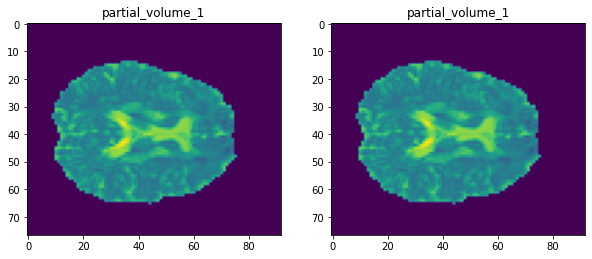

In [5]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(part_vol_one[:,:,0])
ax2.imshow(part_vol_one[:,:,1])
ax1.set_title('partial_volume_1')
ax2.set_title('partial_volume_1')